In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, GroupKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, lasso_path
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

from xgboost import XGBRegressor

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

In [2]:
from utils import REPO_PATH, DATA_PATH, DATA_CLEAN_PATH
from utils import set_plt_settings
from train_functions import scoring, run_cv

set_plt_settings()

## Make analytic datasets

In [3]:
df = pd.read_csv(DATA_CLEAN_PATH / 'analysis_df.csv')

X = df.loc[:, [col for col in df.columns if col.startswith(('ndvi', 'lst'))]]
y = (df.total / df.area_km).to_numpy() # short tons per km^2
g_state = df.statefp

## Regress on all features

In [4]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [5]:
X_lm = sm.add_constant(X_scaled, prepend=False)
lm = sm.OLS(endog=y, exog=X_lm, hasconst=True)
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     1152.
Date:                Sat, 28 May 2022   Prob (F-statistic):               0.00
Time:                        11:06:04   Log-Likelihood:                -73838.
No. Observations:                8199   AIC:                         1.477e+05
Df Residuals:                    8170   BIC:                         1.479e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
lst_consec_mbm_max_mean 

## Run lasso to identify mvp features

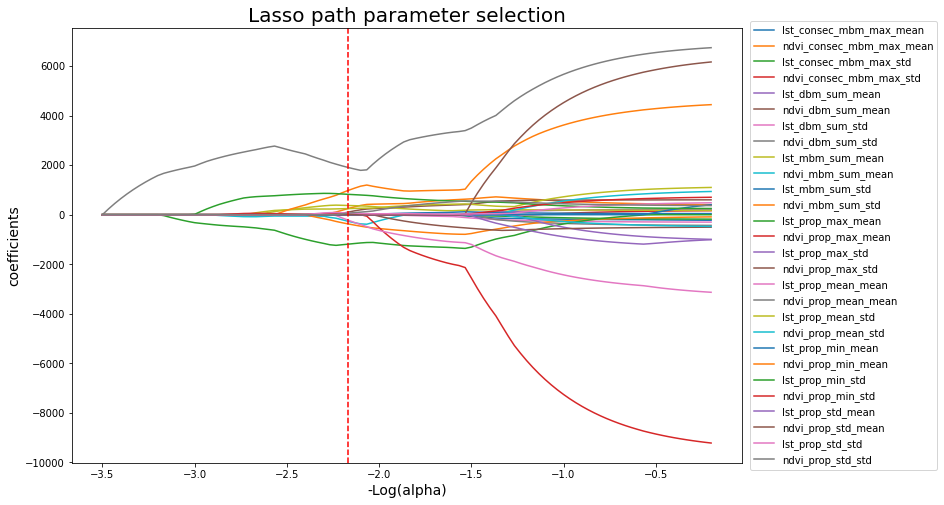

In [26]:
eps = 5e-4  # the smaller it is the longer is the path
a_step = 40
alphas_lasso, coefs_lasso, _ = lasso_path(X_scaled, y, eps=eps)
# Display results
fig, ax = plt.subplots(figsize=(12, 8))
varnames = X_scaled.columns
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, v in zip(coefs_lasso, varnames):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, label=v)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso path parameter selection")
plt.legend(loc='right', bbox_to_anchor=(1.3, .5))
plt.axis("tight")
plt.axvline(x=neg_log_alphas_lasso[a_step], color='r', linestyle='--')
plt.show()

In [28]:
# can we improve regression by selecting these top variables?
top_n = 6
keepcols = varnames[np.argsort(np.abs(coefs_lasso[:, a_step]))[0:top_n]].to_numpy()
print(f'{top_n} most significant variables at alpha {neg_log_alphas_lasso[a_step]}:\n', keepcols)

6 most significant variables at alpha -2.1668321279289966:
 ['lst_consec_mbm_max_mean' 'ndvi_prop_std_mean' 'lst_prop_std_mean'
 'lst_prop_min_mean' 'ndvi_prop_mean_std' 'ndvi_prop_max_std']


In [29]:
X_scaled_lasso = X_scaled.loc[:, keepcols]
X_lm = sm.add_constant(X_scaled_lasso, prepend=False)
lm = sm.OLS(endog=y, exog=X_lm, hasconst=True)
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     2045.
Date:                Sun, 29 May 2022   Prob (F-statistic):               0.00
Time:                        11:45:14   Log-Likelihood:                -76640.
No. Observations:                8199   AIC:                         1.533e+05
Df Residuals:                    8192   BIC:                         1.533e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
lst_consec_mbm_max_mean   